In [1]:
from __future__ import print_function
import os
from os import listdir
from os.path import join
import random
import logging
import time
import copy
from turtle import down
import gdown

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from PIL import Image
from torch.optim.lr_scheduler import StepLR, ReduceLROnPlateau
from torchinfo import summary
from tqdm.notebook import tqdm
from sklearn.metrics import roc_curve, auc, confusion_matrix

from models.cvt import CvT, EqCvT
from typing import *
from utils.util import (
    make_directories,
    seed_everything,
    get_device,
    init_logging_handler,
)
from utils.dataset import download_dataset, DeepLenseDataset, visualize_samples
from utils.train import train
from utils.inference import Inference
from argparse import ArgumentParser
from config.data_config import DATASET
from config.eqcvt_config import EQCVT_CONFIG
from config.pretrained_config import PRETRAINED_CONFIG
from utils.augmentation import get_transform_test, get_transform_train
from torch.utils.data import DataLoader
import timm
from torchvision import models
from models.cnn_zoo import Model, ConViT
import math
from transformers import get_cosine_schedule_with_warmup
import albumentations as A
from albumentations.pytorch import ToTensorV2
from torch.utils.data import DataLoader, Dataset

In [2]:
# run in the case of Colab only
# %%bash
# set -m
# git clone https://github.com/sachdevkartik/GSoC-2022.git
# mv GSoC-2022/* . 
# rm -rf GSoC-2022

In [3]:
dataset_name = "Model_II"
dataset_dir = "data"
use_cuda = True

classes = DATASET[f"{dataset_name}"]["classes"]

train_config = PRETRAINED_CONFIG
network_type = train_config["network_type"]
network_config = train_config["network_config"]
image_size = train_config["image_size"]
optimizer_config = train_config["optimizer_config"]
lr_schedule_config = train_config["lr_schedule_config"]

make_directories([dataset_dir])

In [4]:
trainset = DeepLenseDataset(
    dataset_dir,
    "train",
    dataset_name,
    transform=get_transform_train(upsample_size=387, final_size=PRETRAINED_CONFIG["image_size"], channels=1),
    download=True,
    channels=3
)


Dataset already exists


In [5]:
from torch.utils.data import DataLoader, Dataset, random_split
split_ratio = 0.25
valid_len = int(split_ratio*len(trainset))
train_len = len(trainset) - valid_len
trainset,testset=random_split(trainset,[train_len,valid_len])

/home/kartik/git/GSoC-2022/utils/dataset.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)


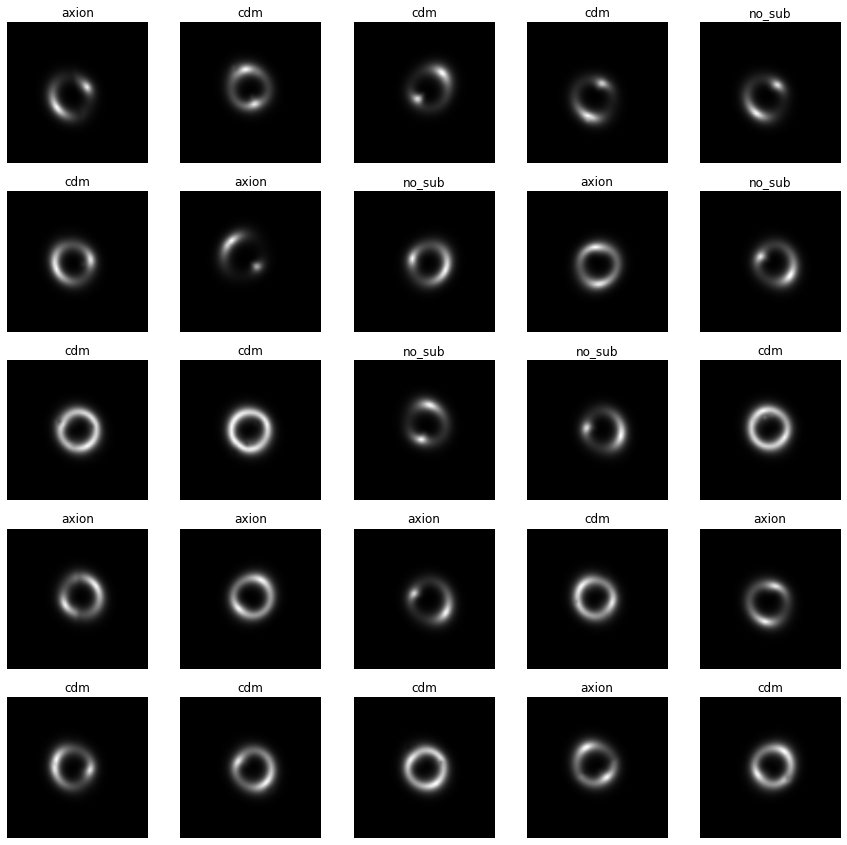

In [6]:
visualize_samples(trainset, classes, fig_height=15, fig_width=15, num_cols=5, cols_rows=5)

In [7]:
len(trainset)

66828

In [8]:
seed_everything(seed=42)
device = get_device(use_cuda=use_cuda, cuda_idx=0)

# logging
current_time = time.strftime("%Y-%m-%d-%H-%M-%S", time.localtime())
log_dir_base = "logger"
log_dir = f"{log_dir_base}/{current_time}"
init_logging_handler(log_dir_base, current_time)

PATH = os.path.join(f"{log_dir}/checkpoint", f"{network_type}_{current_time}.pt")

Using device = cuda:0


In [9]:
train_loader = DataLoader(
    dataset=trainset, batch_size=train_config["batch_size"], shuffle=True, num_workers=12
)
test_loader = DataLoader(
    dataset=testset, batch_size=train_config["batch_size"], shuffle=True, num_workers=12
)

In [10]:
sample = next(iter(train_loader))
sample[0].shape

torch.Size([32, 1, 224, 224])

In [11]:
num_classes = len(classes)  # number of classes to be classified

In [12]:
print(f"Train Data: {len(trainset)}")
print(f"Val Data: {len(testset)}")

Train Data: 66828
Val Data: 22276


In [13]:
# Lightweight CvT
model = CvT(
    channels = 1,           # channels - input channels of image
    num_classes = 3,        # classes - structure type
    s1_emb_dim = 64,        # stage 1 - dimension
    s1_emb_kernel = 7,      # stage 1 - conv kernel size
    s1_emb_stride = 4,      # stage 1 - conv stride
    s1_proj_kernel = 3,     # stage 1 - attention ds-conv kernel size
    s1_kv_proj_stride = 2,  # stage 1 - attention key / value projection stride
    s1_heads = 2,           # stage 1 - heads
    s1_depth = 2,           # stage 1 - depth
    s1_mlp_mult = 4,        # stage 1 - feedforward expansion factor
    s2_emb_dim = 128,       # stage 2 - (same as above)
    s2_emb_kernel = 3,
    s2_emb_stride = 2,
    s2_proj_kernel = 3,
    s2_kv_proj_stride = 2,
    s2_heads = 3,
    s2_depth = 2,
    s2_mlp_mult = 4,
    mlp_last = 256,
    dropout = 0.1
).to(device)

summary(model, input_size=(train_config["batch_size"], 1, image_size, image_size))

Layer (type:depth-idx)                                                 Output Shape              Param #
CvT                                                                    --                        --
├─Sequential: 1-1                                                      [32, 3]                   --
│    └─Sequential: 2-1                                                 [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                                                [32, 64, 56, 56]          3,200
│    │    └─LayerNorm: 3-2                                             [32, 64, 56, 56]          128
│    │    └─Transformer: 3-3                                           [32, 64, 56, 56]          135,168
│    └─Sequential: 2-2                                                 [32, 128, 28, 28]         --
│    │    └─Conv2d: 3-4                                                [32, 128, 28, 28]         73,856
│    │    └─LayerNorm: 3-5                                             [32, 128, 2

In [14]:
# loss function
criterion = nn.CrossEntropyLoss()

# optimizer
optimizer = optim.Adam(model.parameters(), lr=optimizer_config["lr"], betas=optimizer_config["betas"], weight_decay=optimizer_config["weight_decay"])

# scheduler
step_lr = train_config["lr_schedule_config"]["step_lr"]
reduce_on_plateau = train_config["lr_schedule_config"]["reduce_on_plateau"]

scheduler_plateau = ReduceLROnPlateau(optimizer, 'min', factor=reduce_on_plateau["factor"], patience=reduce_on_plateau["patience"], threshold=reduce_on_plateau["threshold"], verbose=reduce_on_plateau["verbose"])
scheduler_step = StepLR(optimizer, step_size=step_lr["step_size"], gamma=step_lr["gamma"])


In [15]:
#optimizer
optimizer = optim.AdamW(model.parameters(), lr=1e-3, weight_decay = 1e-4)
epochs= 10
warmup_epochs = 3
num_train_steps = math.ceil(len(train_loader))
num_warmup_steps= num_train_steps * warmup_epochs
num_training_steps=int(num_train_steps * epochs)

#learning rate scheduler
cosine_scheduler = get_cosine_schedule_with_warmup(optimizer,num_warmup_steps = num_warmup_steps,num_training_steps =num_training_steps) 

In [17]:
train(
    epochs = epochs, # train_config["num_epochs"],
    model = model,
    device = device,
    train_loader = train_loader,
    valid_loader = test_loader, # change to val-loader
    criterion = criterion,
    optimizer = optimizer,
    use_lr_schedule = train_config["lr_schedule_config"]["use_lr_schedule"],
    scheduler_step = cosine_scheduler,
    path = PATH,
)

KeyboardInterrupt: 

In [18]:
MODEL_PATH = 'logger/2022-06-25-20-46-03/checkpoint/convit_tiny_2022-06-25-20-46-03.pt' #/home/kartik/git/GSoC-2022/logger/2022-06-25-20-46-03/checkpoint/convit_tiny_2022-06-25-20-46-03.pt
model.load_state_dict(torch.load(MODEL_PATH))


<All keys matched successfully>

In [19]:
# TODO: change the structure!
infer_obj = Inference(
    model,
    test_loader,
    device,
    num_classes,
    testset,
    dataset_name,
    labels_map=classes,
    image_size=image_size,
    channels=train_config["channels"],
    destination_dir="data",
    log_dir = "logger/2022-06-25-00-58-24", # log_dir
) 

/home/kartik/git/GSoC-2022/utils/dataset.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
/home/kartik/git/GSoC-2022/utils/dataset.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
/home/kartik/git/GSoC-2022/utils/dataset.py:135: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  image = torch.tensor(image, dtype=torch.float32)
/home/kartik/git/GSoC-2022/utils/dataset.py:135: UserWarning: To copy construct from a tensor, it is recommended

<Figure size 640x480 with 0 Axes>

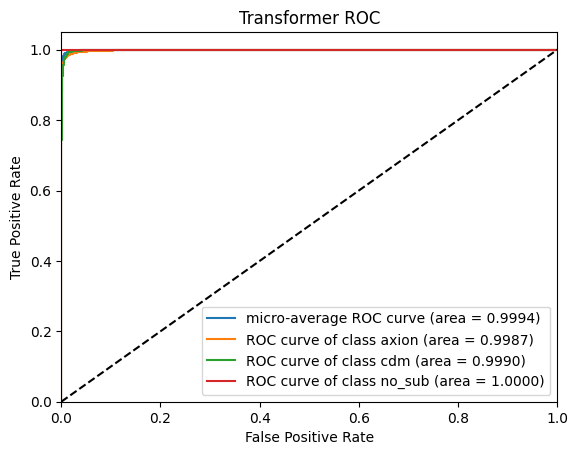

In [20]:
infer_obj.infer_plot_roc()

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3703dbf310>
DEBUG:matplotlib.colorbar:Using auto colorbar locator on colorbar
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f3703dbf310>
DEBUG:matplotlib.colorbar:Setting pcolormesh


Confusion matrix, without normalization


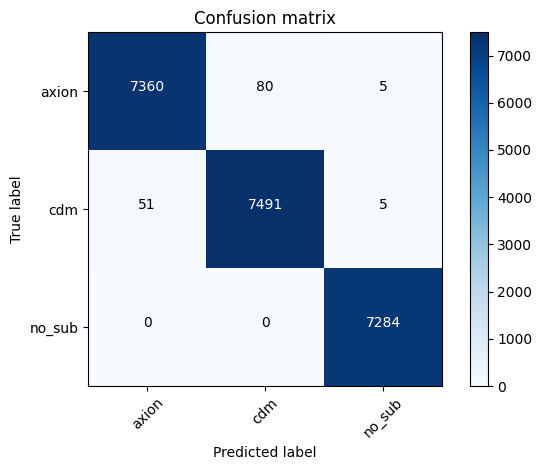

In [21]:
infer_obj.generate_plot_confusion_matrix()